In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

!pip install optuna
!pip install timm
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!pip install torchsampler

torch version: 1.13.1
torchvision version: 0.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 5.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.7/613.7 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 10.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 43.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 43.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
# Continue with regular imports
!pip install matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
!pip install ipython-autotime
%load_ext autotime

[INFO] Couldn't find torchinfo... installing it.
  Using cached ipython_autotime-0.3.1-py2.py3-none-any.whl (6.8 kB)
time: 394 µs (started: 2023-05-08 13:43:53 +00:00)


In [5]:
#unzip the data that we had split earlier before in the preprocessing notebook, to ensure that the same arrangement of data 
#is used for every model. 
!unzip /isic2019-dataset.zip

Archive:  /isic2019-dataset.zip
  inflating: data/ISIC2019.zip       
  inflating: data/test/AK/ISIC_0024468.jpg  
  inflating: data/test/AK/ISIC_0026040.jpg  
  inflating: data/test/AK/ISIC_0026171.jpg  
  inflating: data/test/AK/ISIC_0026626.jpg  
  inflating: data/test/AK/ISIC_0027447.jpg  
  inflating: data/test/AK/ISIC_0029141.jpg  
  inflating: data/test/AK/ISIC_0029915.jpg  
  inflating: data/test/AK/ISIC_0031506.jpg  
  inflating: data/test/AK/ISIC_0031993.jpg  
  inflating: data/test/AK/ISIC_0033358.jpg  
  inflating: data/test/AK/ISIC_0033494.jpg  
  inflating: data/test/AK/ISIC_0053749.jpg  
  inflating: data/test/AK/ISIC_0053879.jpg  
  inflating: data/test/AK/ISIC_0053944.jpg  
  inflating: data/test/AK/ISIC_0053950.jpg  
  inflating: data/test/AK/ISIC_0054081.jpg  
  inflating: data/test/AK/ISIC_0054259.jpg  
  inflating: data/test/AK/ISIC_0054271.jpg  
  inflating: data/test/AK/ISIC_0054433.jpg  
  inflating: data/test/AK/ISIC_0054805.jpg  
  inflating: data/test/AK/ISIC

In [5]:
from torchvision.transforms import Compose, CenterCrop, Normalize, Resize, ToTensor
from torchvision.transforms import InterpolationMode
from torchvision.transforms import RandAugment

# Set the random seed for reproducibility
torch.manual_seed(42)

# Define the transformation parameters
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

time: 2.89 ms (started: 2023-05-07 10:52:03 +00:00)


In [6]:
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import optuna
import timm
import torch.utils.data.sampler as sampler
from torch.utils.data import Subset
from torch.utils.data.sampler import RandomSampler
import torchvision.datasets as datasets
from sklearn import metrics
from sklearn.metrics import f1_score
from torchsampler import ImbalancedDatasetSampler

# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

#define hyperparameter tuning, furthermore we will use 
#10 trials to look for the best hyperparameters. We re-used the optuna hyperparamete optimization code 

# Define the dataset and dataloader
def get_data_loaders(batch_size):

# Load and transform the data

    # Load the datasets
    train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
    val_dataset = datasets.ImageFolder(root='data/valid', transform=transform)

    # load the data and shuffle the training data
    train_dataloader = data.DataLoader(train_dataset, batch_size=32, sampler=ImbalancedDatasetSampler(train_dataset),pin_memory=True, num_workers=4)
    valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    return train_dataloader, valid_dataloader

def get_model(trial, dropout, num_hidden_layers, num_neurons):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_name = 'maxvit_rmlp_small_rw_224'
    model = timm.create_model(model_name, pretrained=True, num_classes=8)
    
    num_in_features = model.get_classifier().in_features

    # Define the classification head with the number of neurons and hidden layers to optimize 
    classifier_layers = []
    for i in range(num_hidden_layers):
        if i == 0:
            in_features = num_in_features
            out_features = num_neurons
        else:
            in_features = num_neurons
            out_features = num_neurons
        classifier_layers.extend([
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Dropout(p=dropout),
        ])
    classifier_layers.append(nn.Linear(num_neurons, 8))
    model.head.fc = nn.Sequential(*classifier_layers)

    # Freeze the weights
    for param in model.parameters():
        param.requires_grad = False
   
    # Unfreeze the classifierhead layer 
    for param in model.head.parameters():
        param.requires_grad = True

    return model

# Define the objective function for Optuna
def objective(trial):
    # Get the hyperparameters to optimize
    batch_size = 32  # set batch size to 32
    epochs = 20  # set epochs to 20
    num_epochs = 20
    optimizer_name = trial.suggest_categorical("optimizer_name", ["AdamW", "SGD"])
    weight_decay = trial.suggest_float("weight_decay", low=0.001, high=0.01, log=True)
    learning_rate = trial.suggest_float("learning_rate", low=0.001, high=0.01, log=True)
    dropout = trial.suggest_categorical("dropout", [0.25,0.5])
    num_hidden_layers = trial.suggest_int("num_hidden_layers", low=1, high=2)
    num_neurons = trial.suggest_categorical("num_neurons", [256, 512])

    # Get the data loaders
    train_dataloader, valid_dataloader = get_data_loaders(batch_size)

    # Get the model
    model = get_model(trial, dropout, num_hidden_layers, num_neurons)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Define the optimizer and loss function
    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

# Initialize variables for early stopping
    best_accuracy = 0.0
    best_val_loss = float('inf')
    best_f1_score = 0.0
    patience = 3
    no_improvement_count = 0

   # Train the model
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        running_total = 0
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                scaler.scale(loss).backward()    # Scale the gradients
                scaler.step(optimizer)           # Update the model parameters
                scaler.update()                  # Update the scaler

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_corrects += (predicted == labels).sum().item()

        # Calculate the training loss and training accuracy
        train_loss = running_loss / len(train_dataloader.dataset)
        train_accuracy = 100 * running_corrects / running_total

        # evaluate on the validation set
        correct = 0
        total = 0
        val_loss = 0.0
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for data in valid_dataloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item() * labels.size(0)

                y_true += labels.cpu().tolist()
                y_pred += predicted.cpu().tolist()

        # Calculate the validation accuracy and validation loss
        accuracy = 100 * correct / total
        val_loss /= len(valid_dataloader.dataset)

        #calculate the macro f1-score
        f1_score = metrics.f1_score(y_true, y_pred, average='macro')

        # Print the accuracy, validation loss, and f1-score
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Validation Loss = {val_loss:.4f}, Validation Accuracy = {accuracy:.2f}%, F1-score = {f1_score:.4f}")

        # Report the intermediate result
        trial.report(f1_score, epoch)

        # Check if the validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Check if the f1 score has improved
        if f1_score > best_f1_score:
            best_f1_score = f1_score

        # Check if early stopping criteria has been met
        if no_improvement_count >= patience:
            print(f"No improvement after {no_improvement_count} epochs. Stopping training...")
            break

    return best_f1_score

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-05-07 10:53:34,238] A new study created in memory with name: no-name-51f1e30c-5aae-4721-9cef-42ad85f761bb
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552843/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 1: Train Loss = 1.2959, Train Accuracy = 53.80%, Validation Loss = 1.2724, Validation Accuracy = 54.08%, F1-score = 0.3940
Epoch 2: Train Loss = 0.9173, Train Accuracy = 67.54%, Validation Loss = 1.1282, Validation Accuracy = 60.45%, F1-score = 0.4512
Epoch 3: Train Loss = 0.8538, Train Accuracy = 69.18%, Validation Loss = 1.1977, Validation Accuracy = 58.92%, F1-score = 0.4419
Epoch 4: Train Loss = 0.8117, Train Accuracy = 70.78%, Validation Loss = 1.2245, Validation Accuracy = 55.62%, F1-score = 0.4254


[I 2023-05-07 11:04:48,201] Trial 0 finished with value: 0.4525281469096978 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.002545287045853775, 'learning_rate': 0.001122415127610856, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 0 with value: 0.4525281469096978.


Epoch 5: Train Loss = 0.7957, Train Accuracy = 71.41%, Validation Loss = 1.1623, Validation Accuracy = 60.64%, F1-score = 0.4525
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.4084, Train Accuracy = 49.05%, Validation Loss = 1.1914, Validation Accuracy = 55.58%, F1-score = 0.4012
Epoch 2: Train Loss = 0.9708, Train Accuracy = 64.76%, Validation Loss = 1.3891, Validation Accuracy = 50.63%, F1-score = 0.3845
Epoch 3: Train Loss = 0.8956, Train Accuracy = 67.79%, Validation Loss = 1.3112, Validation Accuracy = 52.71%, F1-score = 0.4063


[I 2023-05-07 11:13:47,981] Trial 1 finished with value: 0.4085362738067488 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0016534493992826336, 'learning_rate': 0.0037916930813505527, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 0 with value: 0.4525281469096978.


Epoch 4: Train Loss = 0.8462, Train Accuracy = 69.18%, Validation Loss = 1.2436, Validation Accuracy = 57.27%, F1-score = 0.4085
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2649, Train Accuracy = 54.45%, Validation Loss = 1.2363, Validation Accuracy = 57.27%, F1-score = 0.4167
Epoch 2: Train Loss = 0.9340, Train Accuracy = 66.74%, Validation Loss = 1.2272, Validation Accuracy = 57.50%, F1-score = 0.4220
Epoch 3: Train Loss = 0.8642, Train Accuracy = 69.14%, Validation Loss = 1.2499, Validation Accuracy = 55.93%, F1-score = 0.4025
Epoch 4: Train Loss = 0.8269, Train Accuracy = 70.31%, Validation Loss = 1.2572, Validation Accuracy = 54.63%, F1-score = 0.4178
Epoch 5: Train Loss = 0.7932, Train Accuracy = 71.54%, Validation Loss = 1.2110, Validation Accuracy = 58.01%, F1-score = 0.4383
Epoch 6: Train Loss = 0.7840, Train Accuracy = 72.06%, Validation Loss = 1.1574, Validation Accuracy = 60.68%, F1-score = 0.4466
Epoch 7: Train Loss = 0.7624, Train Accuracy 

[I 2023-05-07 11:38:27,903] Trial 2 finished with value: 0.45593565393461727 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0022218713685278457, 'learning_rate': 0.0025922656240842724, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 2 with value: 0.45593565393461727.


Epoch 11: Train Loss = 0.7215, Train Accuracy = 74.02%, Validation Loss = 1.2425, Validation Accuracy = 57.82%, F1-score = 0.4382
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.3984, Train Accuracy = 49.18%, Validation Loss = 1.2121, Validation Accuracy = 55.18%, F1-score = 0.3961
Epoch 2: Train Loss = 0.9819, Train Accuracy = 64.51%, Validation Loss = 1.3865, Validation Accuracy = 47.76%, F1-score = 0.3890
Epoch 3: Train Loss = 0.8928, Train Accuracy = 67.67%, Validation Loss = 1.3420, Validation Accuracy = 51.53%, F1-score = 0.3998


[I 2023-05-07 11:47:26,554] Trial 3 finished with value: 0.39982096676252493 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0019685153319324426, 'learning_rate': 0.0029577271200210563, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 2 with value: 0.45593565393461727.


Epoch 4: Train Loss = 0.8490, Train Accuracy = 69.17%, Validation Loss = 1.3502, Validation Accuracy = 52.24%, F1-score = 0.3876
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2839, Train Accuracy = 54.04%, Validation Loss = 1.2531, Validation Accuracy = 56.40%, F1-score = 0.3978
Epoch 2: Train Loss = 0.9422, Train Accuracy = 67.14%, Validation Loss = 1.1485, Validation Accuracy = 56.87%, F1-score = 0.4328
Epoch 3: Train Loss = 0.8462, Train Accuracy = 69.94%, Validation Loss = 1.1873, Validation Accuracy = 58.25%, F1-score = 0.4466
Epoch 4: Train Loss = 0.8146, Train Accuracy = 71.19%, Validation Loss = 1.0609, Validation Accuracy = 60.92%, F1-score = 0.4509
Epoch 5: Train Loss = 0.7921, Train Accuracy = 71.71%, Validation Loss = 1.0499, Validation Accuracy = 61.90%, F1-score = 0.4547
Epoch 6: Train Loss = 0.7706, Train Accuracy = 72.92%, Validation Loss = 1.1367, Validation Accuracy = 59.07%, F1-score = 0.4501
Epoch 7: Train Loss = 0.7588, Train Accuracy 

[I 2023-05-07 12:05:22,438] Trial 4 finished with value: 0.45469018919129106 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.006681456627420665, 'learning_rate': 0.002289096504312858, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 2 with value: 0.45593565393461727.


Epoch 8: Train Loss = 0.7694, Train Accuracy = 73.07%, Validation Loss = 1.2193, Validation Accuracy = 56.28%, F1-score = 0.4428
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.4260, Train Accuracy = 48.06%, Validation Loss = 1.2777, Validation Accuracy = 52.91%, F1-score = 0.3665
Epoch 2: Train Loss = 0.9754, Train Accuracy = 66.16%, Validation Loss = 1.2086, Validation Accuracy = 56.72%, F1-score = 0.4224
Epoch 3: Train Loss = 0.8607, Train Accuracy = 69.80%, Validation Loss = 1.1594, Validation Accuracy = 58.72%, F1-score = 0.4363
Epoch 4: Train Loss = 0.8012, Train Accuracy = 71.72%, Validation Loss = 1.1807, Validation Accuracy = 58.17%, F1-score = 0.4384
Epoch 5: Train Loss = 0.7717, Train Accuracy = 72.66%, Validation Loss = 1.1438, Validation Accuracy = 59.70%, F1-score = 0.4452
Epoch 6: Train Loss = 0.7502, Train Accuracy = 73.61%, Validation Loss = 1.1116, Validation Accuracy = 60.76%, F1-score = 0.4469
Epoch 7: Train Loss = 0.7285, Train Accuracy 

[I 2023-05-07 12:25:30,447] Trial 5 finished with value: 0.44686033963659666 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0012190501018241292, 'learning_rate': 0.0012299138594196505, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 2 with value: 0.45593565393461727.


Epoch 9: Train Loss = 0.7229, Train Accuracy = 74.28%, Validation Loss = 1.2676, Validation Accuracy = 55.15%, F1-score = 0.4368
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.3273, Train Accuracy = 52.64%, Validation Loss = 1.2000, Validation Accuracy = 58.52%, F1-score = 0.4051
Epoch 2: Train Loss = 0.9431, Train Accuracy = 66.48%, Validation Loss = 1.1403, Validation Accuracy = 57.46%, F1-score = 0.4321
Epoch 3: Train Loss = 0.8442, Train Accuracy = 70.06%, Validation Loss = 1.0797, Validation Accuracy = 60.57%, F1-score = 0.4547
Epoch 4: Train Loss = 0.8038, Train Accuracy = 71.51%, Validation Loss = 1.1059, Validation Accuracy = 60.02%, F1-score = 0.4515
Epoch 5: Train Loss = 0.7816, Train Accuracy = 72.04%, Validation Loss = 1.1610, Validation Accuracy = 56.76%, F1-score = 0.4389


[I 2023-05-07 12:38:59,215] Trial 6 finished with value: 0.45469917404142646 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.005023507341600961, 'learning_rate': 0.0036828244246260543, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 2 with value: 0.45593565393461727.


Epoch 6: Train Loss = 0.7765, Train Accuracy = 72.42%, Validation Loss = 1.1691, Validation Accuracy = 57.15%, F1-score = 0.4258
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.3332, Train Accuracy = 51.71%, Validation Loss = 1.2012, Validation Accuracy = 57.34%, F1-score = 0.4109
Epoch 2: Train Loss = 0.9571, Train Accuracy = 65.57%, Validation Loss = 1.2308, Validation Accuracy = 55.66%, F1-score = 0.4275
Epoch 3: Train Loss = 0.8784, Train Accuracy = 68.49%, Validation Loss = 1.1118, Validation Accuracy = 60.33%, F1-score = 0.4409
Epoch 4: Train Loss = 0.8277, Train Accuracy = 70.25%, Validation Loss = 1.1794, Validation Accuracy = 59.47%, F1-score = 0.4345
Epoch 5: Train Loss = 0.8110, Train Accuracy = 70.51%, Validation Loss = 1.1849, Validation Accuracy = 58.60%, F1-score = 0.4324


[I 2023-05-07 12:52:26,244] Trial 7 finished with value: 0.4408967927074955 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0012558461891047138, 'learning_rate': 0.003208054969055365, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 2 with value: 0.45593565393461727.


Epoch 6: Train Loss = 0.7870, Train Accuracy = 71.32%, Validation Loss = 1.1953, Validation Accuracy = 59.31%, F1-score = 0.4397
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.3209, Train Accuracy = 52.42%, Validation Loss = 1.2029, Validation Accuracy = 58.13%, F1-score = 0.4117
Epoch 2: Train Loss = 0.9229, Train Accuracy = 67.11%, Validation Loss = 1.0889, Validation Accuracy = 60.45%, F1-score = 0.4427
Epoch 3: Train Loss = 0.8301, Train Accuracy = 70.40%, Validation Loss = 1.1339, Validation Accuracy = 59.94%, F1-score = 0.4396
Epoch 4: Train Loss = 0.7975, Train Accuracy = 71.47%, Validation Loss = 1.1110, Validation Accuracy = 61.04%, F1-score = 0.4504


[I 2023-05-07 13:03:40,181] Trial 8 finished with value: 0.45043562729496534 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0013797123651334764, 'learning_rate': 0.0043904741012002705, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 2 with value: 0.45593565393461727.


Epoch 5: Train Loss = 0.7744, Train Accuracy = 72.27%, Validation Loss = 1.1552, Validation Accuracy = 60.25%, F1-score = 0.4364
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.4279, Train Accuracy = 50.11%, Validation Loss = 1.2459, Validation Accuracy = 54.24%, F1-score = 0.3950
Epoch 2: Train Loss = 0.9953, Train Accuracy = 64.43%, Validation Loss = 1.1861, Validation Accuracy = 59.27%, F1-score = 0.4331
Epoch 3: Train Loss = 0.8984, Train Accuracy = 67.70%, Validation Loss = 1.2316, Validation Accuracy = 56.72%, F1-score = 0.4350
Epoch 4: Train Loss = 0.8892, Train Accuracy = 68.05%, Validation Loss = 1.2731, Validation Accuracy = 57.66%, F1-score = 0.4125


[I 2023-05-07 13:14:52,680] Trial 9 finished with value: 0.4349852313773033 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.002115091592437551, 'learning_rate': 0.008669008457002777, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 2 with value: 0.45593565393461727.


Epoch 5: Train Loss = 0.8640, Train Accuracy = 68.93%, Validation Loss = 1.2606, Validation Accuracy = 57.11%, F1-score = 0.4252
No improvement after 3 epochs. Stopping training...
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  0
  Number of complete trials:  10
Best trial:
  Value:  0.45593565393461727
  Params: 
    optimizer_name: AdamW
    weight_decay: 0.0022218713685278457
    learning_rate: 0.0025922656240842724
    dropout: 0.25
    num_hidden_layers: 1
    num_neurons: 256
time: 2h 21min 19s (started: 2023-05-07 10:53:33 +00:00)


/tmp/ipykernel_1936/3515757420.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

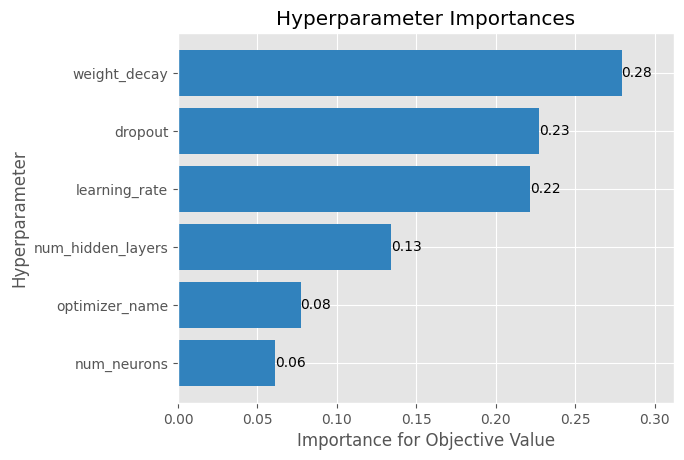

time: 432 ms (started: 2023-05-07 13:14:52 +00:00)


In [7]:
#shows the importance of each hyperparameter
fig = optuna.visualization.matplotlib.plot_param_importances(study)
fig

In [23]:
# Retrieve the best set of hyperparameters
best_params = study.best_params
print(best_params)

{'optimizer_name': 'AdamW', 'weight_decay': 0.0022218713685278457, 'learning_rate': 0.0025922656240842724, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 256}
time: 469 µs (started: 2023-05-08 14:01:10 +00:00)


In [9]:
import os
import shutil

#this code combines both train and validation dataset into one training set, so we can use this to train the model on a larger dataset. 
train_dir = '/data/train'
val_dir = '/data/valid'

# Loop through the subdirectories in val_dir and move their files to train_dir
for class_dir in os.listdir(val_dir):
    src_class_dir = os.path.join(val_dir, class_dir)
    dst_class_dir = os.path.join(train_dir, class_dir)
        
    # Create the destination directory if it doesn't exist yet
    if not os.path.exists(dst_class_dir):
        os.makedirs(dst_class_dir)
        
    # Loop through the files in the source directory and move them to the destination directory
    for file in os.listdir(src_class_dir):
        src_file = os.path.join(src_class_dir, file)
        dst_file = os.path.join(dst_class_dir, file)
        shutil.move(src_file, dst_file)

# Remove the val_dir if it is empty
if not os.listdir(val_dir):
    os.rmdir(val_dir)

time: 64.1 ms (started: 2023-05-07 13:59:32 +00:00)


In [24]:
# loading and transforming the data
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import Subset
from torchsampler import ImbalancedDatasetSampler

# Set the random seed for reproducibility
torch.manual_seed(42)

# Load and transform the data
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

# load the data and shuffle the training data
train_dataloader = data.DataLoader(train_dataset, batch_size=32, sampler=ImbalancedDatasetSampler(train_dataset),pin_memory=True, num_workers=4)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

time: 307 ms (started: 2023-05-08 14:05:26 +00:00)


In [25]:
import timm 
#look up all the maxvit models in timm's library
maxvit_models = timm.list_models('*maxvit*')
maxvit_models

['maxvit_base_224',
 'maxvit_large_224',
 'maxvit_nano_rw_256',
 'maxvit_pico_rw_256',
 'maxvit_rmlp_nano_rw_256',
 'maxvit_rmlp_pico_rw_256',
 'maxvit_rmlp_small_rw_224',
 'maxvit_rmlp_small_rw_256',
 'maxvit_rmlp_tiny_rw_256',
 'maxvit_small_224',
 'maxvit_tiny_224',
 'maxvit_tiny_pm_256',
 'maxvit_tiny_rw_224',
 'maxvit_tiny_rw_256',
 'maxvit_xlarge_224']

time: 116 ms (started: 2023-05-08 14:05:27 +00:00)


In [ ]:
#create the maxvit model
#to create this code, timm's library has been used. 
#create model with new variable name and the best HP values to re-train the model 

import timm 
import torch
import torch.nn as nn

# Set the random seed for reproducibility
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
new_model = timm.create_model('maxvit_rmlp_small_rw_224', pretrained=True, num_classes=8)

num_in_features = new_model.get_classifier().in_features

# Define the classification head
num_hidden_layers = 1
num_neurons = 256
dropout = 0.25
classifier_layers = []
for i in range(num_hidden_layers):
    if i == 0:
        in_features = num_in_features
        out_features = num_neurons
    else:
        in_features = num_neurons
        out_features = num_neurons
    classifier_layers.extend([
        nn.Linear(in_features, out_features),
        nn.BatchNorm1d(out_features),
        nn.Dropout(p=dropout),
    ])
classifier_layers.append(nn.Linear(num_neurons, 8))
new_model.head.fc = nn.Sequential(*classifier_layers)

#freeze the weights
for param in new_model.parameters():
    param.requires_grad = False
   
# unfreeze the last fc layer
for param in new_model.head.parameters():
    param.requires_grad = True


new_model.to(device)

In [27]:
# Print a summary using torchinfo (uncomment for actual output)

summary(model=new_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MaxxVit (MaxxVit)                                                 [32, 3, 224, 224]    [32, 8]              --                   Partial
├─Stem (stem)                                                     [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    └─Conv2d (conv1)                                             [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNormAct2d (norm1)                                     [32, 32, 112, 112]   [32, 32, 112, 112]   64                   False
│    │    └─Identity (drop)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    │    └─SiLU (act)                                            [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Conv2d (conv2)                                  

time: 2.03 s (started: 2023-05-08 14:05:30 +00:00)


In [28]:
# define optimizers and loss function and use the best hyperparameters found during the HP tuning
import torch.optim as optim

# Set the random seed for reproducibility
torch.manual_seed(42)

# define optimizers and loss function. 
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(new_model.parameters(), lr=0.0025922656240842724, weight_decay = 0.0022218713685278457)

time: 2.67 ms (started: 2023-05-08 14:05:32 +00:00)


In [29]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

# Lists to store the loss and accuracy values
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Initialize variables for early stopping
best_test_loss = float('inf')
no_improvement_count = 0
epochs = 11
num_epochs = 11

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    running_total = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()    # Scale the gradients
            scaler.step(optimizer)           # Update the model parameters
            scaler.update()                  # Update the scaler

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_corrects += (predicted == labels).sum().item()

    # Calculate the training loss and training accuracy
    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * running_corrects / running_total

    # evaluate on the test set
    new_model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    y_true = []
    y_scores = []
    y_pred = []
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = new_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item() * labels.size(0)

            # collect the predictions for the metrics calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    # Calculate the test accuracy and test loss
    test_accuracy = 100 * correct / total
    test_loss /= len(test_dataloader.dataset)
  
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")
            
    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

Epoch 1/11: Train Loss: 1.2395, Train Acc: 55.4587, Test Loss: 1.3052, Test Acc: 51.0744
Epoch 2/11: Train Loss: 0.9573, Train Acc: 65.2805, Test Loss: 1.3144, Test Acc: 51.2663
Epoch 3/11: Train Loss: 0.8690, Train Acc: 68.8977, Test Loss: 1.2996, Test Acc: 54.0675
Epoch 4/11: Train Loss: 0.8435, Train Acc: 69.6282, Test Loss: 1.1608, Test Acc: 59.2863
Epoch 5/11: Train Loss: 0.8105, Train Acc: 71.0363, Test Loss: 1.1745, Test Acc: 58.4421
Epoch 6/11: Train Loss: 0.8032, Train Acc: 71.2299, Test Loss: 1.2115, Test Acc: 58.9409
Epoch 7/11: Train Loss: 0.7680, Train Acc: 72.5281, Test Loss: 1.3124, Test Acc: 53.7222
Epoch 8/11: Train Loss: 0.7687, Train Acc: 72.2904, Test Loss: 1.1998, Test Acc: 59.0177
Epoch 9/11: Train Loss: 0.7561, Train Acc: 72.8933, Test Loss: 1.2983, Test Acc: 56.1781
Epoch 10/11: Train Loss: 0.7458, Train Acc: 72.9065, Test Loss: 1.1633, Test Acc: 59.2479
Epoch 11/11: Train Loss: 0.7311, Train Acc: 73.7074, Test Loss: 1.1887, Test Acc: 59.6316
time: 26min 21s (st

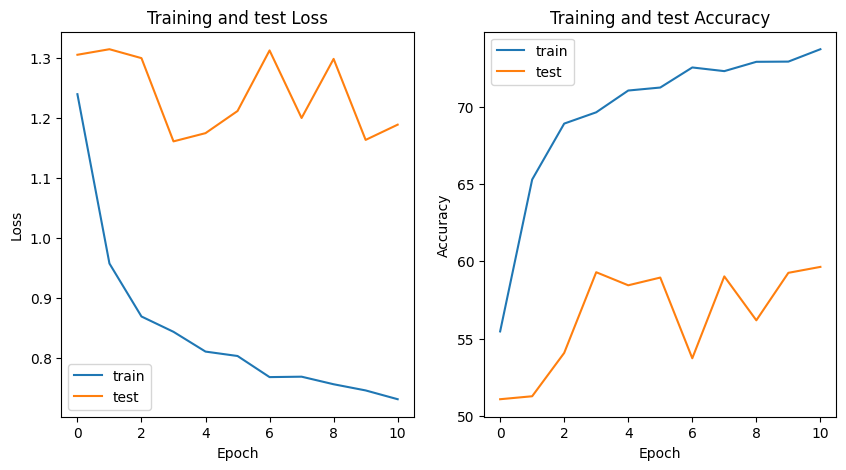

time: 270 ms (started: 2023-05-08 14:31:53 +00:00)


In [30]:
# Plot the validation and training loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and test Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(test_accs, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy')
ax[1].legend()
plt.show()

In [31]:
# Calculate other metrics and the final test accuracy
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np

import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(8)], digits=4)
conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Calculate other metrices
n_classes = conf_mat.shape[0]
sensitivity = 0
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    sensitivity += tp / (tp + fn) * np.sum(conf_mat[i,:])
    specificity += tn / (tn + fp) * np.sum(conf_mat[i,:])
sensitivity /= np.sum(conf_mat)
specificity /= np.sum(conf_mat)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy/100:.4f}") 
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 1.1887
Test Accuracy: 0.5963
Sensitivity: 0.5963
Specificity: 0.8980
ROC-AUC: 0.8424
F1-score: 0.4405
Classification Report:
              precision    recall  f1-score   support

           0     0.2798    0.6067    0.3830        89
           1     0.5583    0.5080    0.5320       311
           2     0.4300    0.4565    0.4429       276
           3     0.1136    0.3704    0.1739        27
           4     0.5112    0.4578    0.4830       450
           5     0.8512    0.6998    0.7681      1349
           6     0.2154    0.5122    0.3032        82
           7     0.3333    0.6364    0.4375        22

    accuracy                         0.5963      2606
   macro avg     0.4116    0.5310    0.4405      2606
weighted avg     0.6614    0.5963    0.6195      2606

time: 468 ms (started: 2023-05-08 14:31:54 +00:00)


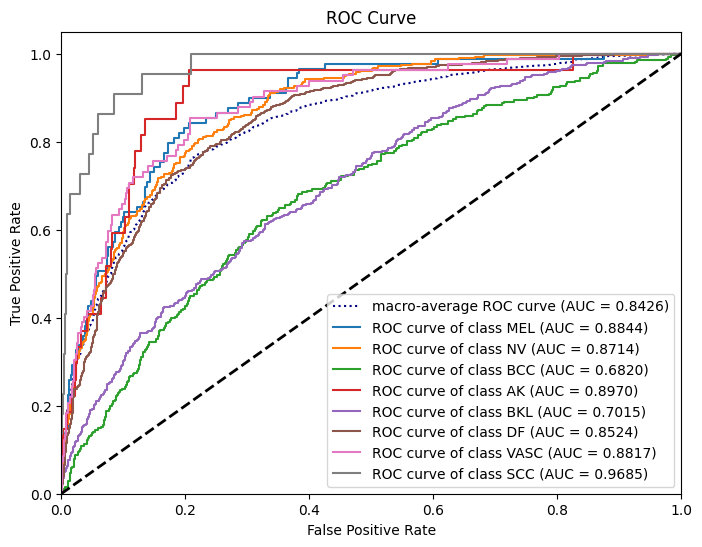

time: 198 ms (started: 2023-05-08 14:31:54 +00:00)


In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Convert the y_true and y_scores lists to arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_true))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (AUC = {0:0.4f})'.format(roc_auc["macro"]), color='navy', linestyle=':')

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.4f})'.format(class_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

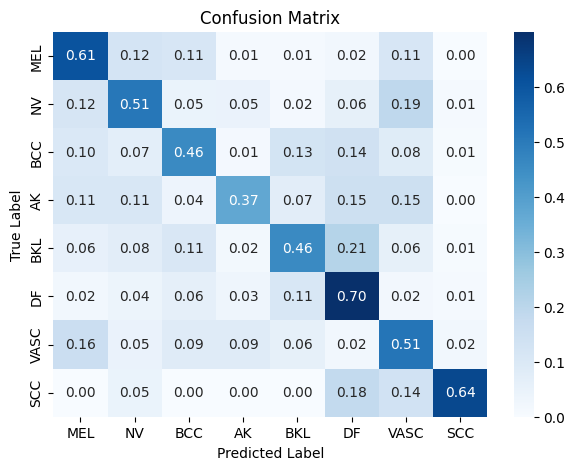

time: 276 ms (started: 2023-05-08 14:31:54 +00:00)


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
class_labels = sorted(list(class_dict.keys()), key=lambda x: int(x))
ax.xaxis.set_ticklabels([class_dict[label] for label in class_labels])
ax.yaxis.set_ticklabels([class_dict[label] for label in class_labels])
plt.show()